Exemple de réseau convolutionnel pour la classification de chiffres manuscrits.

Auteur du code : Yunjey Choi, https://github.com/yunjey/pytorch-tutorial

Cet exemple utilise les fonctions dédiées de PyTorch pour programmer un réseau de neurones : définition du réseau sous forme de classe, utilisation de fonctions dédiées pour le chargement des données. Mais on pourrait évidemment l'écrire avec un code plus basique.

<br>
<br>
Import des librairies : torchvision est la librairie annexe de PyTorch contenant des bases de données classiques, des réseaux de neurones connus préentrainés, ainsi que des fonctions pour le chargement et la manipulation des données.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

<br>
<br>
<br>
La commande suivante permet de sélectionner automatiquement l'unité sur laquelle seront effectués les calculs et où seront transférées les données : processeur classique (CPU) ou carte graphique (GPU).

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


<br>
<br>
<br>
Quelques paramètres : nombres d'"époques", c'est-à-dire le nombre d'itération global de l'algorithme d'entraînement (niter dans le code "circlesquare"), nombre des classes du problème de classification (10 pour les 10 chiffres), etc.

In [3]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

<br>
<br>
<br>
Déclaration du jeu de données à traiter.
On utilise la base MNIST contenant des images de chiffres manuscrits de taille 28*28 en niveau de gris.
Cette base est très classique et contenue dans le module torchvision.

A noter que ces commandes ne font que déclarer les jeu de données ainsi que les itérateurs pour charger ces données,
mais ne charge rien en mémoire encore. Les données seront chargées depuis le disque dur au coup par coup lorsque ce
sera nécessaire. Ceci évite de saturer la mémoire.

A noter également qu'on dispose de deux sous parties "train" et "test" pour l'entraînement et l'évaluation

In [4]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

<br>
<br>
<br>
Affichage des cinq premières images et des labels correspondants. Ici en fait pour simplifier le code on charge directement toutes les données en mémoire, avant d'afficher les 5 premières. Ceci ne cause pas de soucis car le jeu de donnée n'est pas si volumineux. Ceci dit encore une fois on pourrait procéder en chargeant seulement des sous ensembles des données, comme on le fera après dans la boucle d'entraînement du réseau.

tensor([5, 0, 4, 1, 9])


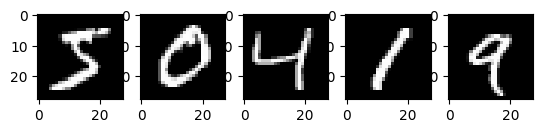

In [5]:
labels = train_dataset.targets
print(labels[0:5])
images = train_dataset.data
import numpy as np
import matplotlib.pyplot as plt
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(images[k,:,:], cmap="gray")
plt.show()

<br>
<br>
<br>
Définition du réseau : il est implémenté sous forme d'une classe qui doit dériver de la classe nn.Module.

La première fonction __init__ est le constructeur de la classe ; on y définit deux couches convolutionnelles similaires qui enchaînent une opération de convolution, une renormalisation, une opération ReLu et un pooling, ainsi qu'une couche finale "dense" de multiplication simple par une matrice. En interne à chaque définition de ces opérations, les paramètres internes des couches (filtres des convolutions et matrice) sont créés et initialisés. C'est donc l'équivalent des lignes "fa=... fb=... m=..." dans le code "circlesquare".

La deuxième fonction "forward" définit le calcul à effectuer pour appliquer le réseau à des données : on exécute les trois couches successivement, en intercalant un "reshape" avant la dernière opération pour être compatible avec la dernière multiplication matricielle simple.

In [6]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

<br>
<br>
<br>
On crée à présent un objet de la classe ConvNet qui vient d'être définie. L'objet est instancié par défaut sur la mémoire classique, puis le ".to(device)" final permet de le transférer sur la mémoire du GPU dans le cas où il est disponible (sinon la commande n'a pas d'effet).

In [7]:
model = ConvNet(num_classes).to(device)

<br>
<br>
<br>
Déclaration de la fonction qui servira de coût à optimiser, et de l'algorithme d'optimisation :

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<br>
<br>
<br>
Etape d'entraînement : deux boucles imbriquées ; une pour les itérations globales ("époques") et pour chacune de ces époques une boucle pour parcourir toutes les données par paquets successifs. Ici num_epochs = 5, batch_size = 100 et il y a 60000 images dans les données d'entraînement, donc on effectue 10 itérations globales et 600 itérations internes.

A noter que le chargement des données à chaque itération interne se fait via l'objet train_loader qui est un fait un itérateur : on peut créer une boucle permettant de charger chaque paquet de donnée successivement via la commande
```python
for images, labels in train_loader:
    ... # dans ce bloc images et labels contiennent le paquet de données courant
    ... # (100 images et leurs labels correspondants)
```
Ici la syntaxe utilisée pour la boucle for ajoute "enumerate" qui fournit simplement un compteur i=0,1,2,... en plus.

Remarque : attention cette étape est évidemment la plus longue ; en l'absence de GPU, il faut attendre plusieurs minutes pour qu'elle se termine (le message "training done" doit apparaître à la fin)

In [9]:
# Train the model
print("beginning training...")
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
print("training done")

beginning training...
Epoch [1/5], Step [100/600], Loss: 0.0751
Epoch [1/5], Step [200/600], Loss: 0.1015
Epoch [1/5], Step [300/600], Loss: 0.1336
Epoch [1/5], Step [400/600], Loss: 0.1269
Epoch [1/5], Step [500/600], Loss: 0.0344
Epoch [1/5], Step [600/600], Loss: 0.0199
Epoch [2/5], Step [100/600], Loss: 0.0336
Epoch [2/5], Step [200/600], Loss: 0.0178
Epoch [2/5], Step [300/600], Loss: 0.0451
Epoch [2/5], Step [400/600], Loss: 0.0172
Epoch [2/5], Step [500/600], Loss: 0.0303
Epoch [2/5], Step [600/600], Loss: 0.0287
Epoch [3/5], Step [100/600], Loss: 0.0912
Epoch [3/5], Step [200/600], Loss: 0.1239
Epoch [3/5], Step [300/600], Loss: 0.0047
Epoch [3/5], Step [400/600], Loss: 0.0109
Epoch [3/5], Step [500/600], Loss: 0.0535
Epoch [3/5], Step [600/600], Loss: 0.0180
Epoch [4/5], Step [100/600], Loss: 0.0998
Epoch [4/5], Step [200/600], Loss: 0.0019
Epoch [4/5], Step [300/600], Loss: 0.0053
Epoch [4/5], Step [400/600], Loss: 0.0267
Epoch [4/5], Step [500/600], Loss: 0.0197
Epoch [4/5],

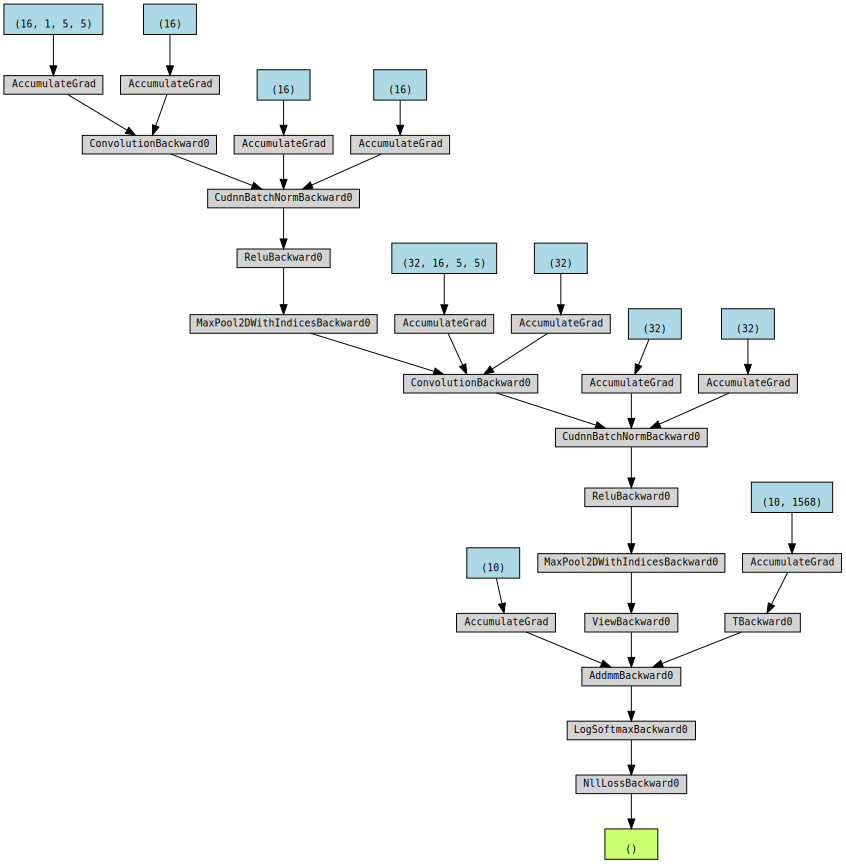

In [14]:
#!pip install torchviz
from torchviz import make_dot
make_dot(loss)

<br>
<br>
<br>
A présent le réseau est entraîné. On peut évaluer sa performance pour la classification des chiffres manuscrits en classant de nouvelles données (les données test) et en comptant le taux de bonnes classifications.

In [10]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 99.09 %


<br>
<br>
<br>
Pour tester à la main quelques exemples, on affiche les cinq premières images du dernier batch de test, ainsi que leurs labels, puis on applique le réseau final et on détermine les labels prédits par le réseau pour comparer.

vrais labels :  tensor([8, 9, 0, 1, 2], device='cuda:0')
labels prédits par le réseau :  tensor([8, 9, 0, 1, 8], device='cuda:0')


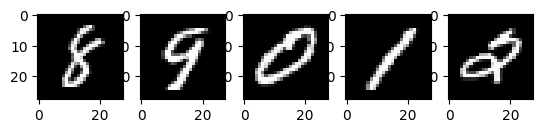

In [19]:
import numpy as np
import matplotlib.pyplot as plt
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(images[k,0,:,:].cpu(), cmap="gray")
print("vrais labels : ",labels[0:5])
outputs = model(images[0:5,:,:,:])
_, predicted = torch.max(outputs.data, 1)
print("labels prédits par le réseau : ",predicted)

<br>
<br>
<br>
Un petit test supplémentaire : on applique le réseau à la superposition d'une image du chiffre 8 (première image test du dernier batch) et d'une image du chiffre 0 (3e image), pour voir dans quelle catégorie il la classe.

tensor([0], device='cuda:0')

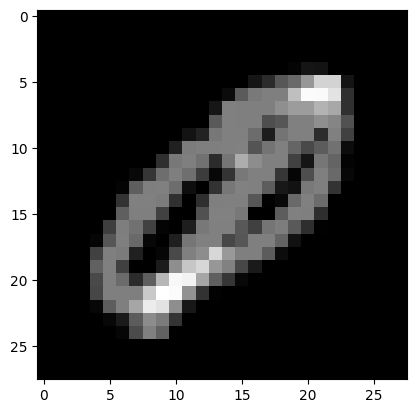

In [20]:
image80 = images[2,:,:,:]+images[3,:,:,:]
image80 = image80.unsqueeze(1)
outputs = model(image80)
_, predicted = torch.max(outputs.data, 1)
plt.imshow(image80[0,0,:,:].cpu(), cmap="gray")
predicted

<br>
<br>
<br>
Enfin on va afficher des exemples d'images mal classées. Comme il y en a très peu, il faut sans doute parcourir plusieurs batchs successifs des données de test avant de trouver au moins une image mal classée. C'est ce qui est fait dans la boucle suivante :

In [24]:
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    if (predicted == labels).sum().item()<100:
        break


<br>
<br>
<br>
Le batch chargé à présent contient une ou plusieurs images mal classées. On les affiche en indiquant leurs vrais labels et les labels prédits :

vrais labels :  tensor([9], device='cuda:0')
labels prédits :  tensor([4], device='cuda:0')


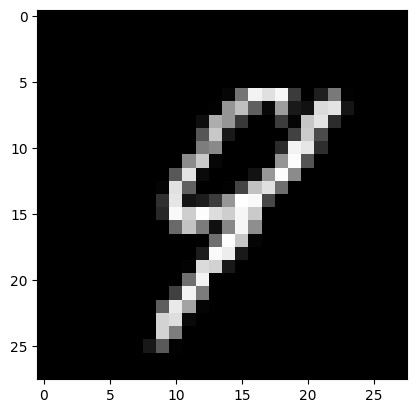

In [27]:
ind, = torch.where((predicted!=labels))
print("vrais labels : ",labels[ind])
print("labels prédits : ",predicted[ind])
for k in range(len(ind)):
    plt.subplot(1,len(ind),k+1)
    plt.imshow(images[ind[k],0,:,:].cpu(), cmap="gray")